In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from scipy import interpolate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import random_split

class Conv1DNet(nn.Module):
    def __init__(self):
        super(Conv1DNet, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=7, stride=2, padding=3)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=16, kernel_size=7, stride=2, padding=3)
        self.convtrans1 = nn.ConvTranspose1d(in_channels=16, out_channels=16, kernel_size=7, stride=2, padding=3, output_padding=1)
        self.convtrans2 = nn.ConvTranspose1d(in_channels=16, out_channels=32, kernel_size=7, stride=2, padding=3, output_padding=1)
        self.convtrans3 = nn.ConvTranspose1d(in_channels=32, out_channels=3, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = F.relu(self.convtrans1(x))
        x = self.dropout(x)
        x = F.relu(self.convtrans2(x))
        x = self.dropout(x)
        x = self.convtrans3(x)
        x = F.softmax(x, dim=1)
        return x

def gen_trace(amp =0.9, amp2=0.7, noise_amp=.015, n=500):
    # Generate fake top hat data
    rnd = sorted(np.random.random_sample((3,)))
    start,middle,stop = rnd[0],rnd[1],rnd[2]
    t = np.linspace(0, 1, n)
    vals = np.zeros(n)
    vals[t>start]= amp
    vals[t>middle]= amp2
    vals[t>stop] = 0
    spikeamp = sorted(np.random.random_sample((1,)))[0]/2
    if spikeamp> 0.2:
        vals[abs(t-start)<0.015] = spikeamp
    vals = smooth(vals)
    noise = np.random.normal(0, noise_amp, (500))
    raw = vals + noise

    # label fake top hat data
    labels = np.zeros(n)
    labels[t>start]= 2
    labels[t>stop] = 0
    labels[abs(t-start)<.025] = 1
    labels[abs(t-stop)<.025] = 1
    labels[abs(t-middle)<.025] = 1

    encoded_labels = np.zeros((n,3))
    encoded_labels[:,0] = labels==0
    encoded_labels[:,1] = labels==1
    encoded_labels[:,2] = labels==2

    return  raw, encoded_labels



In [9]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    x = np.array(x)
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    if window == 'flat':
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    N = window_len
    spad = np.pad(x, (N//2, N-1-N//2), mode='edge')
    ret = np.convolve(w/w.sum(),spad,mode='valid')

    assert len(ret) == len(x)
    return ret

In [10]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

# Generate data
num_samples = 1000  # Number of samples to generate
x_train = []
y_train = []

for _ in range(num_samples):
    raw, labels = gen_trace()
    x_train.append(raw)
    # Convert labels to single class labels if necessary. Here we choose the max label as class.
    y_train.append(np.argmax(labels, axis=1))

x_train = np.array(x_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

# Convert to PyTorch tensors
x_train = torch.from_numpy(x_train)
y_train = torch.from_numpy(y_train).long()
# Create DataLoader
dataset = TensorDataset(x_train, y_train)  # Add channel dimension
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Assuming x_train and y_train tensors are already defined

full_dataset = TensorDataset(x_train, y_train)

# Calculate the sizes of each dataset
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset = full_dataset

# Create DataLoader for each set
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [15]:
x_val = np.load("brightness_signals.npy")
y_val = np.load("brightness_validation_predictions.npy")

x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.long)

val_dataset = TensorDataset(x_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True)

In [17]:
# Initialize the model, loss function, optimizer, and lists to store metrics
model = Conv1DNet()  # Ensure Conv1DNet is correctly defined
criterion = nn.CrossEntropyLoss()  # Adjust if needed based on your model, including weights if necessary
optimizer = optim.Adam(model.parameters(), lr=0.001)

training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

# Define the accuracy calculation function
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.float().unsqueeze(1)  # Adjust inputs for 1D CNN
            labels = labels.squeeze()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)*500
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# Training loop
epochs = 40
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.unsqueeze(1)  # Adjust inputs for 1D CNN
        outputs = model(inputs)
        loss = criterion(outputs, labels.squeeze())  # Adjust if needed based on your model
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    training_losses.append(running_loss / len(train_loader))
    training_acc = calculate_accuracy(model, train_loader)
    training_accuracies.append(training_acc)

    # Validation
    val_running_loss = 0.0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.float().unsqueeze(1)  # Adjust inputs for 1D CNN
            outputs = model(inputs)
            val_loss = criterion(outputs, labels.squeeze())
            val_running_loss += val_loss.item()

    validation_losses.append(val_running_loss / len(val_loader))
    validation_acc = calculate_accuracy(model, val_loader)
    validation_accuracies.append(validation_acc)

    print(f'Epoch {epoch+1}, Training Loss: {running_loss / len(train_loader)}, Training Accuracy: {training_acc:.2f}, Validation Loss: {val_running_loss / len(val_loader)}, Validation Accuracy: {validation_acc:.2f}')







Epoch 1, Training Loss: 1.0476831905543804, Training Accuracy: 0.86, Validation Loss: 0.9213024377822876, Validation Accuracy: 0.69
Epoch 2, Training Loss: 0.8617775477468967, Training Accuracy: 0.86, Validation Loss: 0.803639829158783, Validation Accuracy: 0.69
Epoch 3, Training Loss: 0.7412736378610134, Training Accuracy: 0.86, Validation Loss: 0.8660824596881866, Validation Accuracy: 0.69
Epoch 4, Training Loss: 0.6943833865225315, Training Accuracy: 0.86, Validation Loss: 0.8330743610858917, Validation Accuracy: 0.69
Epoch 5, Training Loss: 0.6913275457918644, Training Accuracy: 0.86, Validation Loss: 0.818693220615387, Validation Accuracy: 0.69
Epoch 6, Training Loss: 0.6890482157468796, Training Accuracy: 0.87, Validation Loss: 0.7551089227199554, Validation Accuracy: 0.72
Epoch 7, Training Loss: 0.6811581403017044, Training Accuracy: 0.88, Validation Loss: 0.7574444115161896, Validation Accuracy: 0.77
Epoch 8, Training Loss: 0.6740932129323483, Training Accuracy: 0.88, Validatio

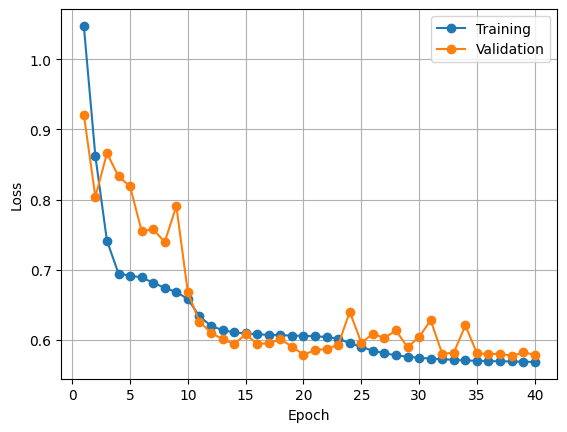

In [18]:
# Plotting loss and accuracy with points
plt.figure()
epochs_range = range(1, epochs + 1)
plt.plot(epochs_range, training_losses, label='Training', marker='o')
plt.plot(epochs_range, validation_losses, label='Validation', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()


plt.show()


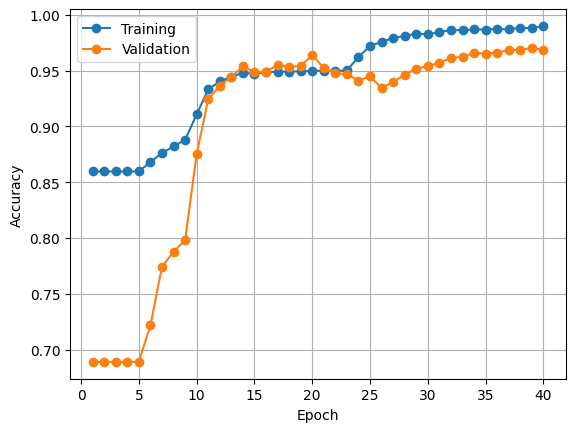

In [19]:
# Plot Training and Validation Accuracy
plt.figure()
plt.plot(epochs_range, training_accuracies, label='Training', marker='o')
plt.plot(epochs_range, validation_accuracies, label='Validation', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()


In [20]:
# Generate a single test input sequence
test_raw, test_labels = gen_trace()
test_input = torch.tensor(test_raw, dtype=torch.float).unsqueeze(0).unsqueeze(1)  # Shape: [1, 1, 500]


In [21]:
test_input = torch.tensor(test_raw, dtype=torch.float).unsqueeze(0).unsqueeze(1)  # Shape: [1, 1, 500]

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_output = model(test_input)
    probabilities = F.softmax(test_output, dim=1)
    predictions = torch.argmax(test_output, dim=1)#.squeeze()  # Shape: [500]

test_input_flat = test_input.squeeze().cpu().numpy()

# Convert probabilities to numpy for easy handling
probabilities_np = predictions.squeeze().cpu().numpy()  # Shape: [num_classes, 500]

# Time steps for x-axis
time_steps = np.arange(test_input_flat.shape[0])

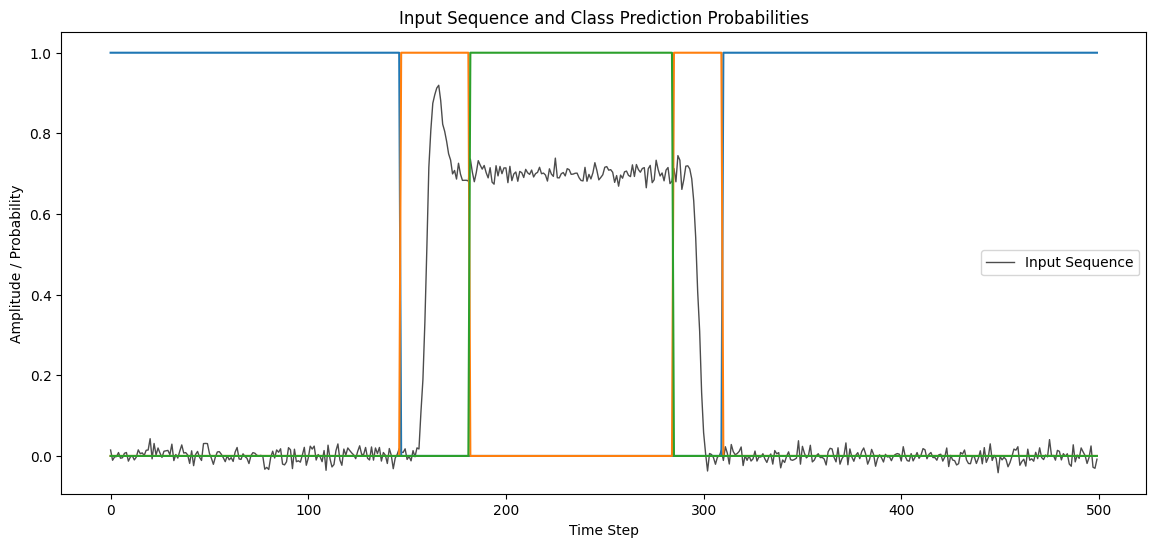

In [22]:
import matplotlib.pyplot as plt

time_steps = np.arange(test_input_flat.shape[0])

plt.figure(figsize=(14, 6))

# Plot the input sequence
plt.plot(time_steps, test_raw, label='Input Sequence', color='black', linewidth=1, alpha=0.7)

# Plot prediction probabilities for each class
class_colors = ['red', 'green', 'blue']  # Colors for classes 0, 1, 2
class_labels = ['Class 0 Prob', 'Class 1 Prob', 'Class 2 Prob']  # Labels for classes 0, 1, 2


plt.plot(time_steps, test_labels)

plt.title('Input Sequence and Class Prediction Probabilities')
plt.xlabel('Time Step')
plt.ylabel('Amplitude / Probability')
plt.legend()
plt.show()



In [23]:

test_input = torch.tensor(test_raw, dtype=torch.float).unsqueeze(0).unsqueeze(1)  # Shape: [1, 1, 500]

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    test_output = model(test_input)
    # # Convert logits to probabilities (optional)
    probabilities = F.softmax(test_output, dim=1)
    # Get the predicted class for each time step
    predictions = torch.argmax(test_output, dim=1)#.squeeze()  # Shape: [500]
# Flatten test_input for plotting
test_input_flat = test_input.squeeze().cpu().numpy()

# Convert probabilities to numpy for easy handling
probabilities_np = predictions.squeeze().cpu().numpy()  # Shape: [num_classes, 500]

# Time steps for x-axis
time_steps = np.arange(test_input_flat.shape[0])


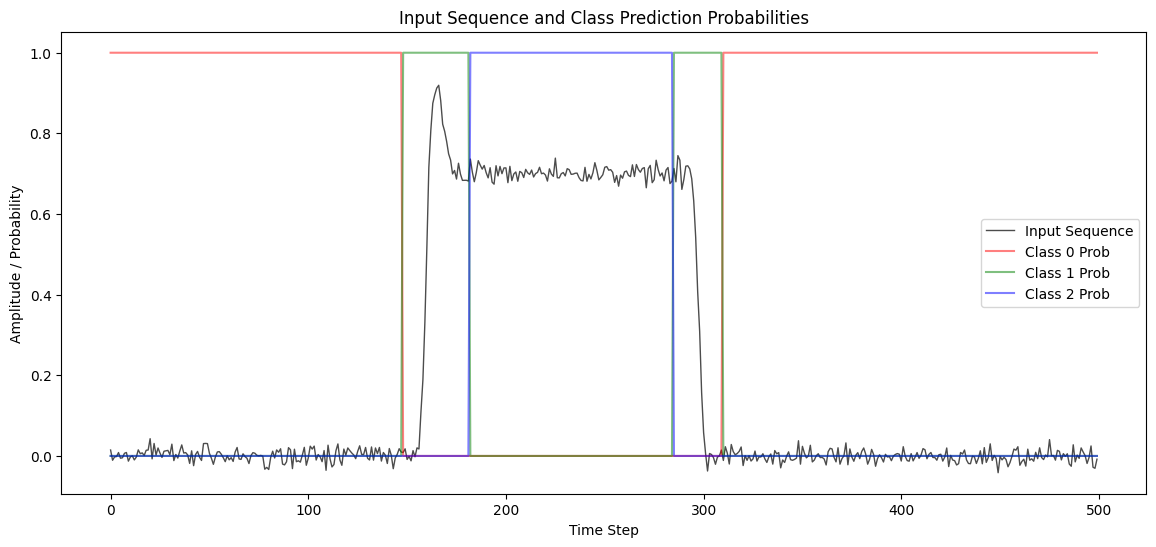

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot the input sequence
plt.plot(time_steps, test_input_flat, label='Input Sequence', color='black', linewidth=1, alpha=0.7)

# Plot prediction probabilities for each class
class_colors = ['red', 'green', 'blue']  # Colors for classes 0, 1, 2
class_labels = ['Class 0 Prob', 'Class 1 Prob', 'Class 2 Prob']  # Labels for classes 0, 1, 2

for i, color in enumerate(class_colors):
    plt.plot(time_steps, predictions.squeeze() == i, label=class_labels[i], color=color, alpha=0.5)

plt.title('Input Sequence and Class Prediction Probabilities')
plt.xlabel('Time Step')
plt.ylabel('Amplitude / Probability')
plt.legend()
plt.show()


In [26]:
import numpy as np

def gen_trace(amp=0.9, amp2=0.7, noise_amp=0.015, n=500):
    # Generate fake top hat data
    rnd = sorted(np.random.random_sample((3,)))
    start, middle, stop = rnd[0], rnd[1], rnd[2]
    t = np.linspace(0, 1, n)
    vals = np.zeros(n)
    vals[t > start] = amp
    vals[t > middle] = amp2
    vals[t > stop] = 0
    spikeamp = sorted(np.random.random_sample((1,)))[0] / 2
    if spikeamp > 0.2:
        vals[abs(t - start) < 0.015] = spikeamp
    vals = np.convolve(vals, np.ones(10)/10, mode='same')  # Example smoothing
    noise = np.random.normal(0, noise_amp, n)
    raw = vals + noise

    # Label fake top hat data
    labels = np.zeros(n)
    labels[t > start] = 2
    labels[t > stop] = 0
    labels[abs(t - start) < .025] = 1
    labels[abs(t - stop) < .025] = 1
    labels[abs(t - middle) < .025] = 1

    return raw, labels

# Example usage
raw_data, labels = gen_trace()


In [27]:
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No need to calculate gradients
        for inputs, labels in data_loader:
            # Adjust inputs for 1D CNN
            inputs = inputs.float().unsqueeze(1)
            labels = labels.squeeze()
            outputs = model(inputs)

            # Get the predicted class for each input
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)*500
            correct += (predicted == labels).sum().item()
    print(total)

    accuracy = correct / total
    return accuracy

# Calculate accuracy on the validation set
val_accuracy = calculate_accuracy(model, val_loader)
print(f'Validation Accuracy: {val_accuracy:.2f}')


35500
Validation Accuracy: 0.97
